Importing modules

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mode
import chiCa
from spks import *
from spks.sync import load_ni_sync_data,interp1d

%matplotlib widget

Loading nidaq and behavior data

In [2]:
animal = 'GRB006'
session = '20240429_174359'
sessionpath = Path('/home/data/GRB006/20240429_174359/')
sync_port = 0 # this is where the SMA of the probe is connected

(nionsets,nioffsets),(nisync,nimeta),(apsyncdata) = load_ni_sync_data(sessionpath=sessionpath)
aponsets = apsyncdata[0]['file0_sync_onsets'][6] # this should be the same for you, its where the sync is on the probe

corrected_onsets = {} # This is a dictionary with the digital events that were connected to the breakout box.
for k in nionsets.keys():
    corrected_onsets[k] = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nionsets[k]).astype('uint64')
del k

# if you need analog channels those are in "nisync"
nitime = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(np.arange(len(nisync)))

# everything is in samples, use this sampling rate
srate = apsyncdata[0]['sampling_rate']  

frame_rate = mode(1/(np.diff(corrected_onsets[1])/srate)) #corrected_onsets[1] are the frame samples, [2] are the trial start samples

analog_signal = nisync[:, 0] # analog stim signal

behavior_data = chiCa.load_trialdata('/home/data/GRB006/20240429_174359/chipmunk/GRB006_20240429_174359_chipmunk_DemonstratorAudiTask.mat')

/opt/conda/envs/spks-gabriel/lib/python3.12/site-packages/chiCa/chipmunk_analysis_tools.py:321: UserWarning: Found multisensory trials, assumed synchronous condition
  warnings.warn('Found multisensory trials, assumed synchronous condition')


Grab stim event times

In [3]:
t = nitime/srate #nidaq clock time vector in seconds
amp_threshold = 15000 #signal amplitude threshold
time_threshold = 0.04 #in seconds - minimum time between stim events
ii = np.where(np.diff(analog_signal>amp_threshold)==1)[0]
stim_ts = t[ii[np.diff(np.hstack([0,ii]))>time_threshold*srate]]
del amp_threshold, time_threshold, ii

# for accesing trial by trial information such as first stim onset and trial outcome
stim_ts_per_trial = pd.DataFrame()
first_stim_ts = [] #first in each trial
for ti in range(len(corrected_onsets[2]) - 1):
    start_time = corrected_onsets[2][ti] / srate
    end_time = corrected_onsets[2][ti + 1] / srate
    events_in_interval = stim_ts[(stim_ts > start_time) & (stim_ts < end_time)]
    first_stim_ts = np.nan
    if len(events_in_interval) > 0:
        first_stim_ts = events_in_interval[0]
    
    stim_ts_per_trial = pd.concat([stim_ts_per_trial, pd.DataFrame({
        "trial_index": [ti],
        "trial_rate": [len(behavior_data.stimulus_event_timestamps[ti])],
        "detected_events": [len(events_in_interval)],
        "stim_ts": [events_in_interval],
        "first_stim_ts": [first_stim_ts], 
        "trial_outcome": [behavior_data.outcome_record[ti]]
    })], ignore_index=True)

del ti, start_time, end_time, events_in_interval

Loading and filtering KS results

In [4]:
from utils import get_good_units

kilosort_path = Path('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/')
sc = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_clusters.npy') #KS clusters
ss = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_times.npy') #KS spikes (in samples)
st = ss/srate #conversion from spike samples to spike times

clu = Clusters(folder = kilosort_path, get_waveforms=False, get_metrics=True, load_template_features=True)

good_unit_ids, n_units = get_good_units(clusters_obj = clu, spike_clusters = sc)


Static population PSTH plotting

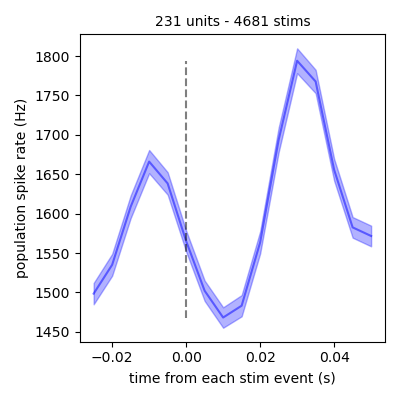

In [10]:
from utils import get_cluster_spike_times, compute_mean_sem
from viz import plot_psth
from spks.event_aligned import compute_firing_rate

binwidth_ms = 5
tpre = 0.025
tpost = 0.055

population_timestamps = st[good_unit_ids]
# four_Hz_stim_ts = np.hstack(stim_ts_per_trial[stim_ts_per_trial.bpod_events == 20].event_times) #filter for a specific trial rate type
psth, _ = compute_firing_rate(stim_ts, population_timestamps, tpre, tpost, binwidth_ms, kernel=None)
n_stims = len(psth)

plt.figure(figsize=(4, 4))
plot_psth(compute_mean_sem(psth), tpre, tpost, binwidth_ms, 'time from each stim event (s)', 'population spike rate (Hz)', f"{n_units} units - {n_stims} stims")

In [6]:
# #loop over all stim rates, plot pop psth for those stim events, and save fig
# for rate in np.unique(stim_ts_per_trial.trial_rate):
#     ts = np.hstack(stim_ts_per_trial[stim_ts_per_trial.bpod_events == rate].event_times)
#     psth, _ = compute_firing_rate(ts, population_timestamps, tpre, tpost, binwidth_ms, kernel=None)
#     n_stims = len(psth)

#     plt.figure(figsize=(4, 4))
#     plot_psth(compute_mean_sem(psth), tpre, tpost, binwidth_ms, 'time from each stim event (s)', 'population spike rate (Hz)', f"{rate} Hz trials\n{n_units} neurons - {n_stims} stims")
#     filename = f"pop_stim_kernel_{rate}_Hz.png"
#     save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/stim_kernels_per_rate/')
#     filepath = os.path.join(save_dir, filename)
#     plt.savefig(filepath)

# del rate, ts, psth, n_stims

Stim responses by outcome

In [186]:
(unit_fr[0]).shape

(2901, 16)

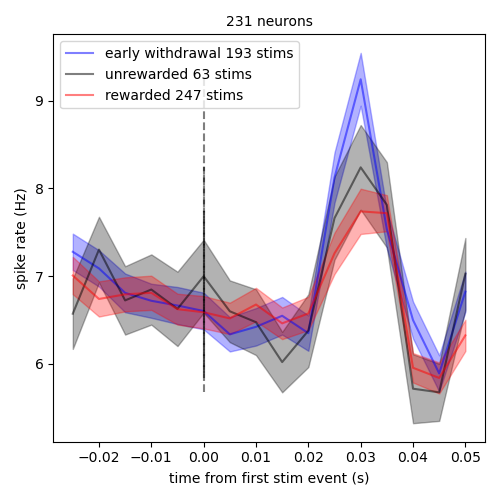

In [192]:
#loop over all outcomes, plot pop psth for those stim events, and save fig
plt.figure(figsize=(5, 5))
for outcome, c in zip(np.unique(stim_ts_per_trial.trial_outcome), ['b', 'k', 'r', 'y']):
    ts = np.hstack(stim_ts_per_trial[stim_ts_per_trial.trial_outcome == outcome].first_stim_ts)
    unit_fr = []
    with suppress_print():
        for i in range(len(single_unit_timestamps)):
            try:
                unit_fr.append(compute_firing_rate(ts, single_unit_timestamps[i], tpre, tpost, binwidth_ms, kernel=None)[0])
            except:
                unit_fr.append(np.nan)
    psth = np.mean(unit_fr, axis = 0)
    # psth, _ = compute_firing_rate(ts, population_timestamps, tpre, tpost, binwidth_ms, kernel=None)
    n_stims = len(psth)

    if outcome == 0:
        txt = 'unrewarded'
    elif outcome == 1:
        txt = 'rewarded'
    elif outcome == -1:
        txt = 'early withdrawal'
    elif outcome == 2:
        txt = 'no choice'

    plot_psth(compute_mean_sem(psth), tpre, tpost, binwidth_ms,
              xlabel = 'time from first stim event (s)',
              ylabel = 'spike rate (Hz)',
              fig_title = f"{n_units} neurons",
              data_label = f'{txt} {n_stims} stims',
              color=c)
    # filename = f"pop_stim_kernel_{rate}_Hz.png"
    # save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/stim_kernels_per_rate/')
    # filepath = os.path.join(save_dir, filename)
    # plt.savefig(filepath)
plt.legend()
del outcome, ts, psth, n_stims

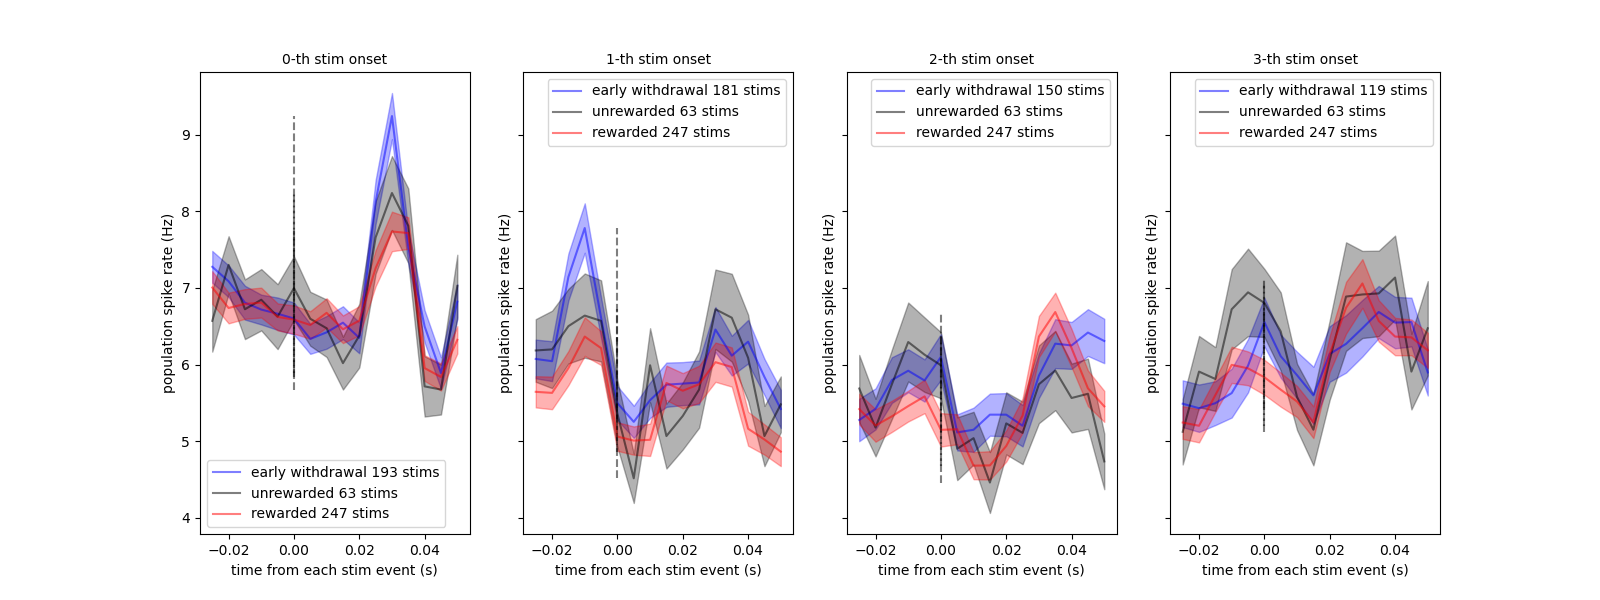

In [208]:
from utils import suppress_print, get_nth_element

binwidth_ms = 5
tpre = 0.025
tpost = 0.055

#loop over all outcomes, plot pop psth for those stim events, and save fig
fig, axs = plt.subplots(1,4,figsize=(16,6), sharex = True, sharey = True)
fig.subplots_adjust(hspace=0)
for i, ax in enumerate(axs):
    for outcome, c in zip(np.unique(stim_ts_per_trial.trial_outcome), ['b', 'k', 'r', 'y']):
        ts = np.hstack(stim_ts_per_trial[stim_ts_per_trial.trial_outcome == outcome].stim_ts.apply(lambda x: get_nth_element(x, i)))
        # psth, _ = compute_firing_rate(ts, population_timestamps, tpre, tpost, binwidth_ms, kernel=None)
        unit_fr = []
        for ii in range(len(single_unit_timestamps)):
            with suppress_print():
                unit_fr.append(compute_firing_rate(ts, single_unit_timestamps[ii], tpre, tpost, binwidth_ms, kernel=None)[0])
        pop_rate = np.mean(unit_fr, axis = 0)

        n_stims = pop_rate.shape[0]

        if outcome == 0:
            txt = 'unrewarded'
        elif outcome == 1:
            txt = 'rewarded'
        elif outcome == -1:
            txt = 'early withdrawal'
        elif outcome == 2:
            txt = 'no choice'

        plot_psth(compute_mean_sem(pop_rate), tpre, tpost, binwidth_ms,
                xlabel = 'time from each stim event (s)',
                ylabel = 'population spike rate (Hz)',
                data_label = f'{txt} {n_stims} stims',
                fig_title = f'{i}-th stim onset',
                color=c,
                ax = ax,
                tight=False)
    ax.legend()

del outcome, ts, n_stims

Single neuron interactive viewer

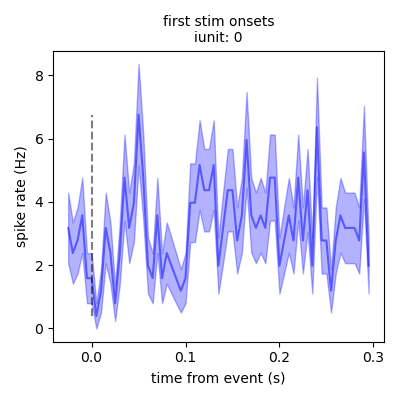

In [216]:
from viz import individual_psth_viewer

binwidth_ms = 5
tpre = 0.025
tpost = 0.3

# single_unit_timestamps = get_cluster_spike_times(spike_times = st, spike_clusters = sc, good_unit_ids = good_unit_ids)

plt.figure(figsize=(4, 4))
individual_psth_viewer(event_times = stim_ts_per_trial.first_stim_ts, 
                       single_unit_timestamps = single_unit_timestamps, 
                       pre_seconds = tpre, 
                       post_seconds = tpost, 
                       binwidth_ms = binwidth_ms, 
                       save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/'),
                       fig_title = 'first stim onsets')

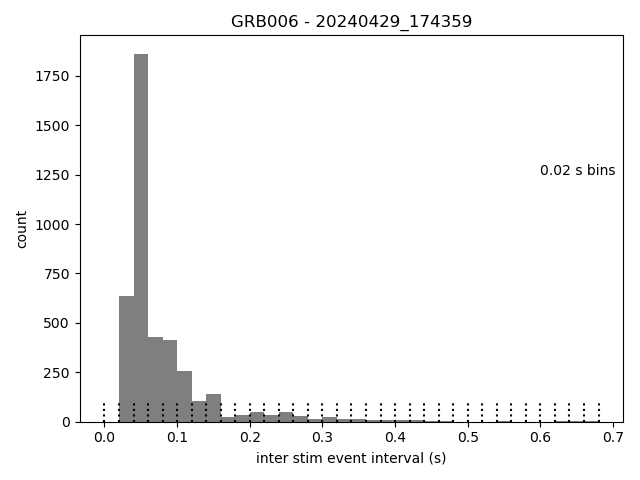

In [36]:
plt.figure()
plt.hist(np.diff(stim_ts), np.arange(0, 0.7, 0.02), color='k', alpha = 0.5)
plt.vlines(np.arange(0, 0.7, 0.02), 0, 100, color='k', alpha = 1, linestyles='dotted')
plt.xlabel('inter stim event interval (s)')
plt.ylabel('count')
plt.title(f'{animal} - {session}')
plt.text(0.6, 1250, '0.02 s bins')
plt.tight_layout()
# plt.plot(np.diff(stim_ts))

In [ ]:
len(nionsets[sync_port]), len(aponsets)